# Simulated-based-inference of 2D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

#from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi
#from sbi.utils.get_nn_models import posterior_nn

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [6]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI_master'

In [7]:
Res_dir='Res_Epileptor2D_sde_sbi'

### Simulator

In [8]:
def Epileptor2Dmodel(params, constants, sigma, dt, ts):
   
    eta, tau, x_init, z_init  = params[0], params[1], params[2], params[3]
    
    eta.astype(float)
    tau.astype(float)
    x_init.astype(float)
    z_init.astype(float)

    
    # fixed parameters
    I1=constants[0]
    nt=ts.shape[0]
    dt = np.float(dt)
    sigma = np.float(sigma)
    
    # simulation from initial point
    x = np.zeros(nt)  # fast voltage
    z = np.zeros(nt)  # slow voltage
    states=np.zeros((2,nt))

    x[0] = np.float(x_init)    
    z[0] = np.float(z_init) 
    
    for i in range(1, nt):
        dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
        dz =(1.0/tau)*(4*(x[i-1]-eta) - z[i-1])
        x[i]=x[i-1] + dt * dx +  np.sqrt(dt)*sigma*np.random.randn()
        z[i]=z[i-1] + dt * dz +  np.sqrt(dt)*sigma*np.random.randn()
        
    states=  np.concatenate((np.array(x).reshape(-1), np.array(z).reshape(-1)))   
    
    return states
     

In [9]:
Epileptor2Dmodel = numba.jit(Epileptor2Dmodel)

In [10]:
def nullclines(X,Y, tau, eta):  
    I1=3.1
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  4*(X-eta) - Y
    plt.contour(X, Y, dX, 0, colors='b', linewidths=(2.,))
    plt.contour(X, Y, dY, 0, colors='b', linewidths=(2.,))
    
    x = np.r_[-5:5:0.01]
    z = np.r_[0:10:0.01]
    xx, zz = np.meshgrid(x,z)
    dx = np.zeros([len(z),len(x)])
    dz = np.zeros([len(z),len(x)])

    for ii in range(len(z)):
        for jj in range(len(x)):
            dx[ii,jj] = 1 - x[jj]**3 - 2*x[jj]**2 - z[ii] + I1
            dz[ii,jj] = 1/tau*(4*(x[jj] - eta) - z[ii])
    plt.streamplot(x,z,dx,dz,density=2.0, color='deepskyblue', linewidth=1.5 , zorder=1)

In [11]:
def root_fuc(roots, eta):   
    xx = np.empty(1)
    zz = np.empty(1)
    F = np.empty(2)
    xx = roots[0]
    zz = roots[1]
    I1=3.1
    F[0] =1.0 - xx**3 - 2.0*xx**2 - zz + I1 
    F[1] =4*(xx-eta) - zz
    return np.array([F[0], F[1]])

In [12]:
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

rGuess=array([[-1.,3.]])

In [13]:
eta_true=-1.5
tau_true=10.
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


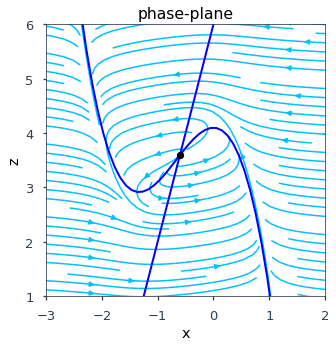

In [14]:
plt.figure(figsize=(5, 5))
nullclines(X,Z, tau_true, eta_true)
#plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
plt.scatter(true_roots[0], true_roots[1], s=28, facecolors='k', edgecolors='k', linewidth=2., zorder=3)
plt.xlabel('x'); plt.ylabel('z'); 
plt.title('phase-plane')
plt.xlim((-3,2)), plt.ylim((1,6))
plt.show()

### sanity check simulations

In [15]:
T = 100.0
dt=0.1
ts = np.arange(0, T + dt, dt)
nt=ts.shape[0]

In [16]:
I1=3.1
constants = np.array([I1])

In [17]:
sigma=1e-1

In [18]:
# three sets of params (eta, tau, x0, z0)
params = np.array([[-3.5, 10., -2.5, 3.5],[-2.1, 10., -2.5, 3.5],[-1.5, 10., -2.5, 3.5]])
params.shape

(3, 4)

In [19]:
num_p = len(params[:,0])
sim_p_x = np.zeros((num_p, nt))
num_p,sim_p_x.shape

(3, (3, 1001))

In [20]:
start_time = time.time()
i=0
_ = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)
print(" single sim takes (sec):" , (time.time() - start_time))

 single sim takes (sec): 0.7898845672607422


In [21]:
start_time = time.time()
i=0
_ = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)
print(" single sim with numba takes (sec):" , (time.time() - start_time))

 single sim with numba takes (sec): 0.0014102458953857422


In [22]:
start_time = time.time()

for i in range(num_p):
    sim_p_x[i,:] = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)[0:nt]
    
print("similations with numba takes (sec):" , (time.time() - start_time))    

similations with numba takes (sec): 0.0018589496612548828


/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


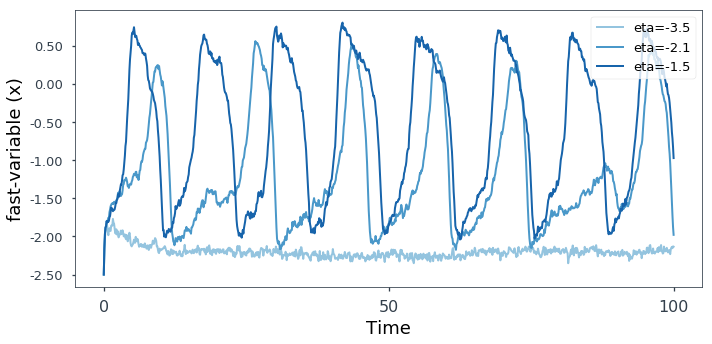

In [23]:
col_min = 2
num_colors = num_p+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


fig = plt.figure(figsize=(10,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_p):
    plt.plot(ts,sim_p_x[i,:],color=col1[i], lw=2, label='eta='+str(params[i,0]))

plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.legend(loc='upper right')
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_xticks([0, max(ts)/2, max(ts)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.tight_layout();
plt.show()

In [24]:
def Epileptor2Dmodel_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 100.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    I1=3.1
    constants = np.array([I1])
    
    sigma=1e-1
    nt=ts.shape[0]
    
    states = Epileptor2Dmodel(params, constants, sigma, dt, ts)

    return states.reshape(-1)  

## 3. Prior over model parameters

In [25]:
prior_min = [-5.0, 0.1, -5.0, 0.0]
prior_max = [0.0, 50.0, 0.0, 5.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [26]:
start_time = time.time()

posterior = infer(Epileptor2Dmodel_simulator_wrapper, prior, method='SNPE', num_simulations=10000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 143 epochs.
------------------------------------------------------------
--- 1229.6429526805878 seconds ---


### EZ

In [27]:
# true parameters and respective labels
labels_params = [r'$\eta$', r'$\tau$', r'$x_{init}$', r'$z_{init}$']

In [28]:
true_params = np.array([-1.6, 10., -2.5, 3.5])

In [29]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [30]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

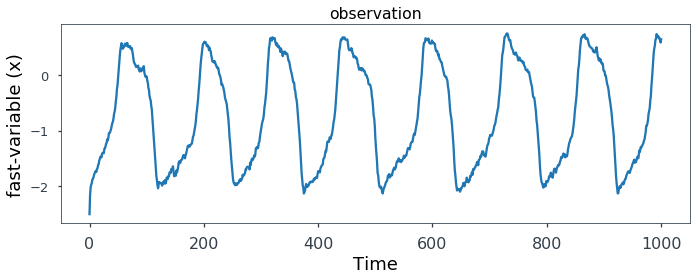

In [31]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.eps"), doi=800)
plt.show()

### Posterior EZ

In [32]:
num_samples=10000

In [33]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [34]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_ez_posterior_samples.npy') , posterior_samples)

In [35]:
num_params=posterior_samples.shape[1]

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


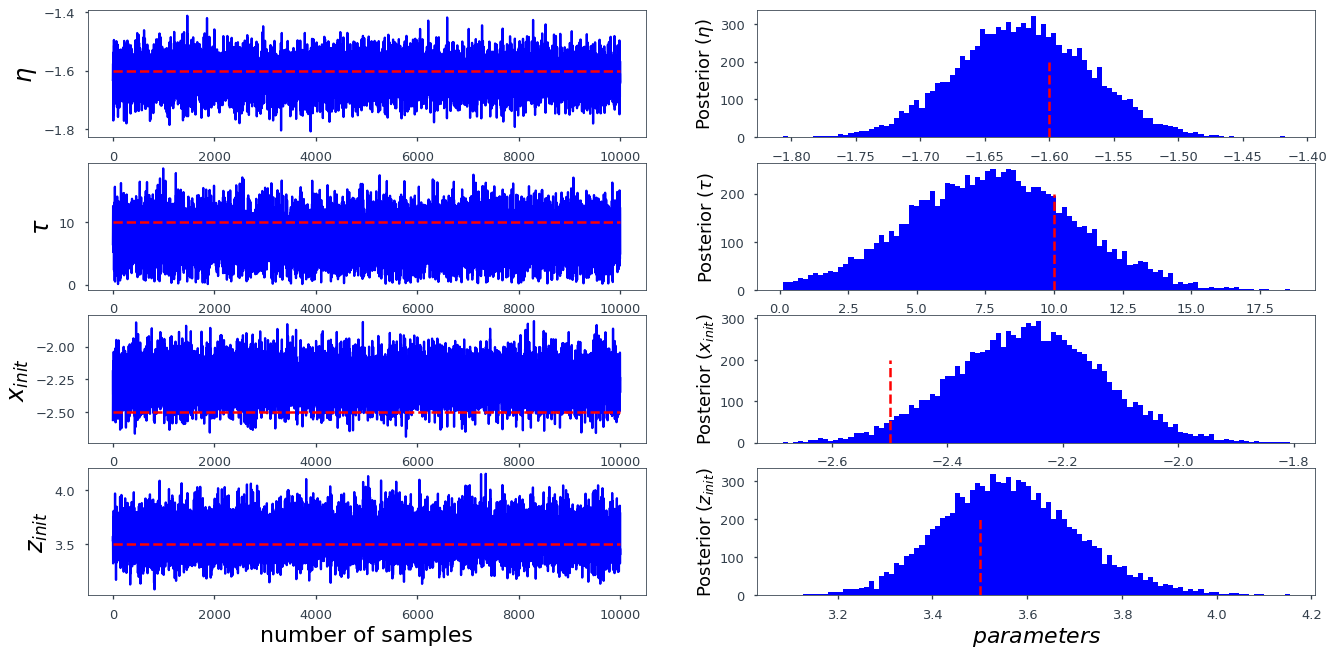

In [36]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.eps"), doi=800)   
plt.show()

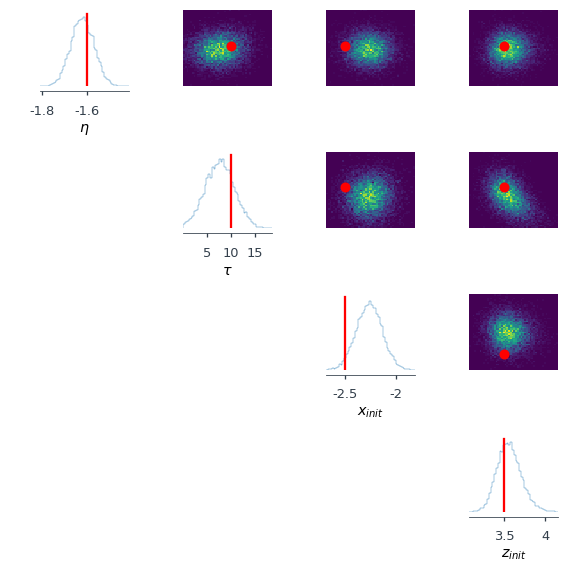

In [37]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.eps"), doi=800) 
plt.show()

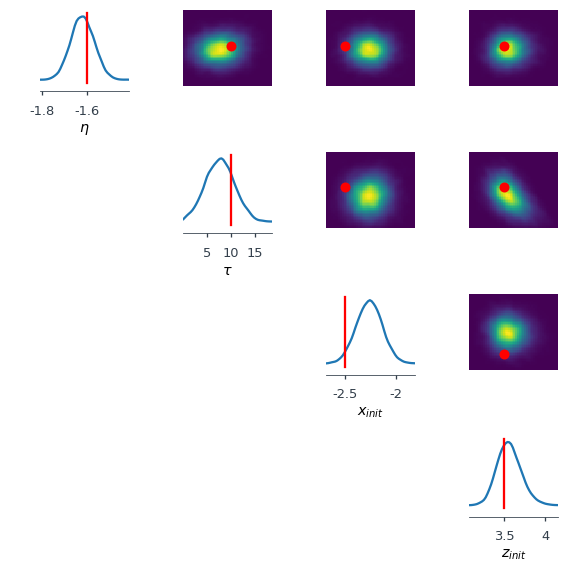

In [38]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.eps"), doi=800)
plt.show()

In [39]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [40]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [41]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_ez_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_ez_y_fit.npy') , y_fit)

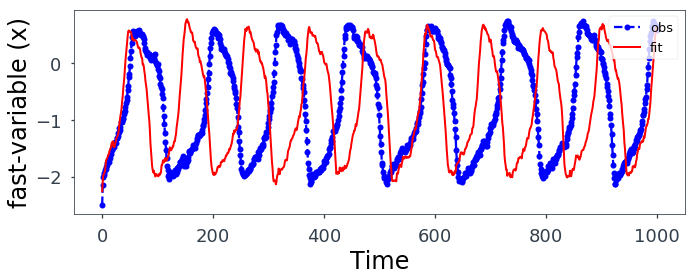

In [42]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.eps"), doi=800)  
plt.show()

In [43]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [44]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


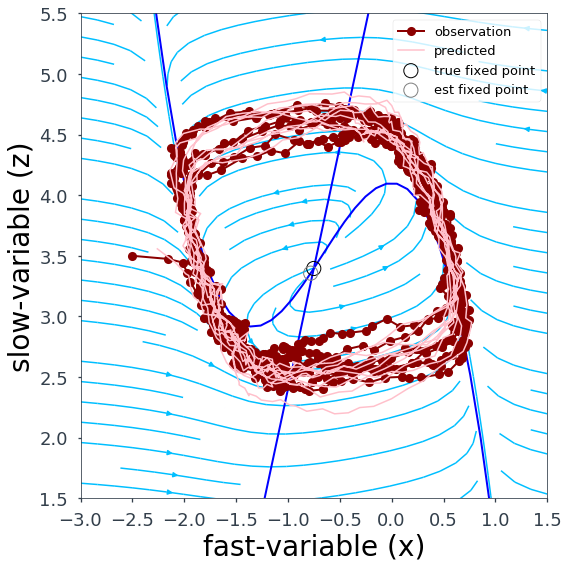

In [45]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkred', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='pink', alpha=1, linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
#plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=14, color='cyan', label='true fixed point')
#plt.plot(est_roots[0], est_roots[1] , marker="o", markersize=14, color='y', label='est fixed point')
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='none', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='none', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_ez.eps"), doi=800) 
plt.show()

### PZ

In [46]:
true_params = np.array([-2.1, 10., -2.5, 3.5])

In [47]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [48]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

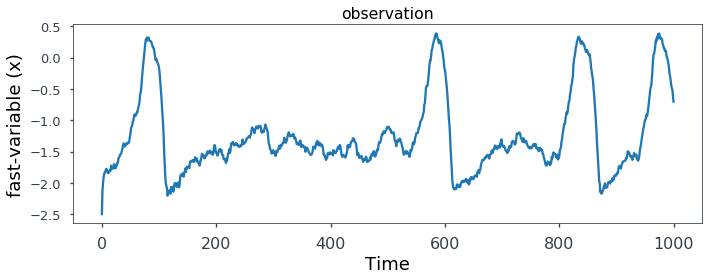

In [49]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.eps"), doi=800)
plt.show()

### Posterior PZ

In [50]:
num_samples=10000

In [51]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [52]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_pz_posterior_samples.npy') , posterior_samples)

In [53]:
num_params=posterior_samples.shape[1]

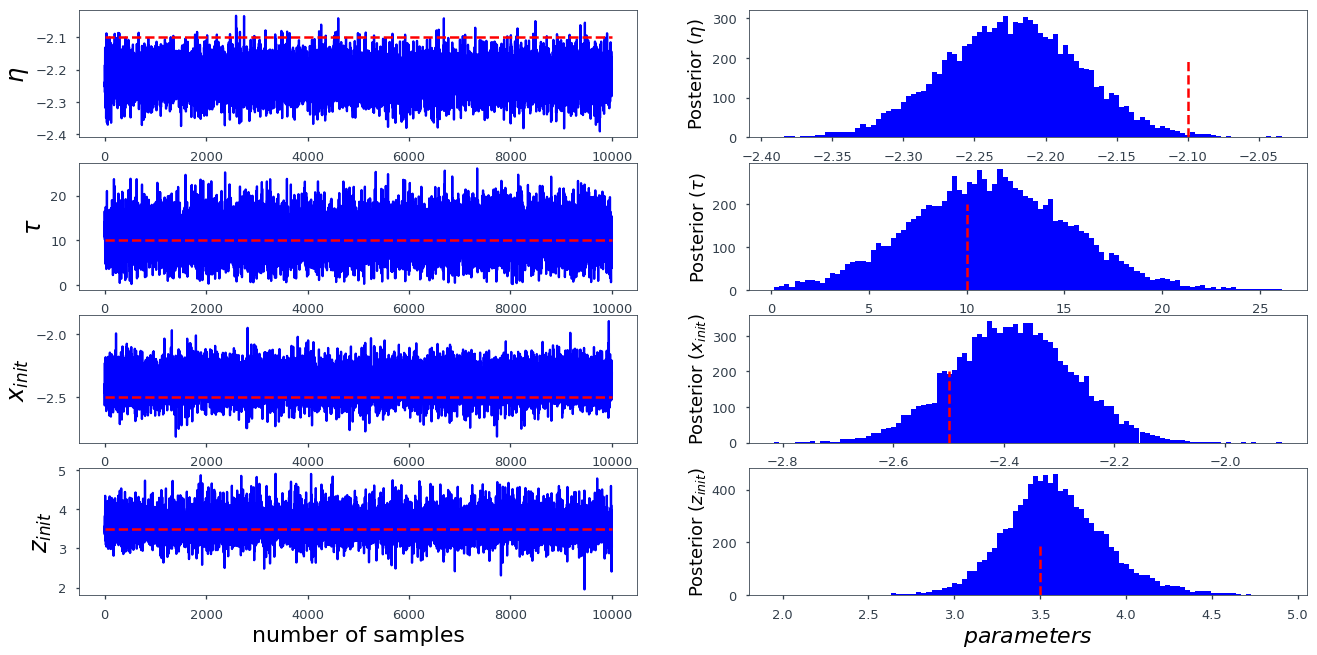

In [54]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.eps"), doi=800)     
plt.show()

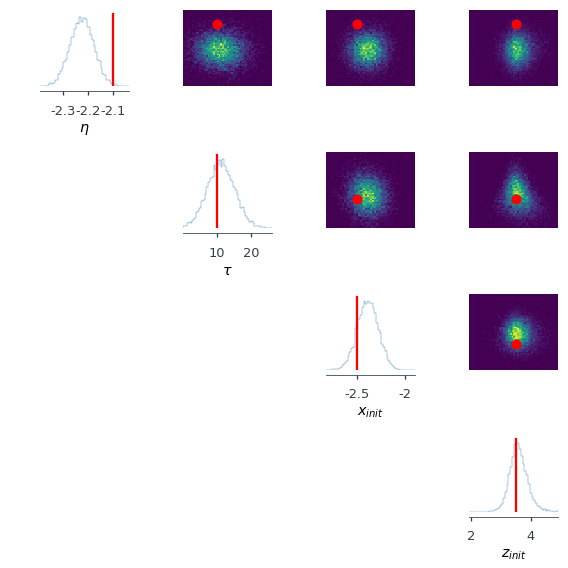

In [55]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.eps"), doi=800) 
plt.show()

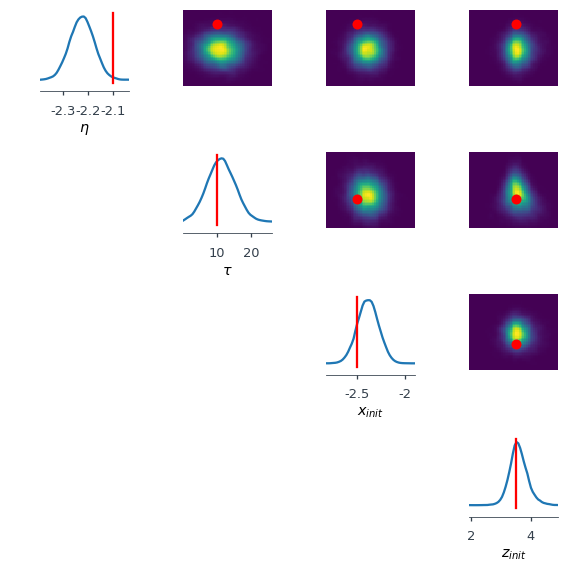

In [56]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.eps"), doi=800)  
plt.show()

In [57]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [58]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [59]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_pz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_pz_y_fit.npy') , y_fit)

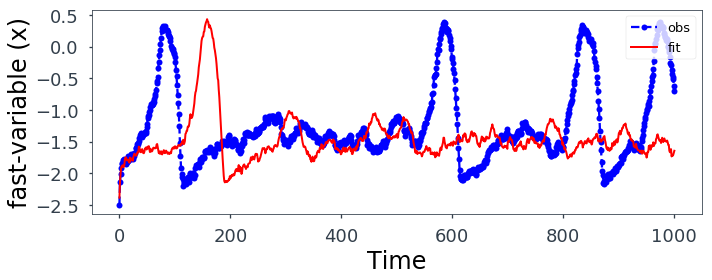

In [60]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.eps"), doi=800)
plt.show()

In [61]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [62]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

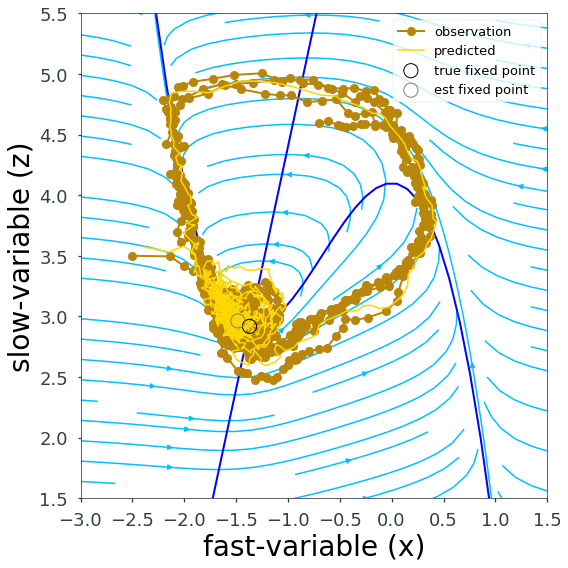

In [63]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkgoldenrod', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='gold', alpha=1, linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='none', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='none', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_p1.eps"), doi=800) 
plt.show()

### HZ

In [64]:
true_params = np.array([-3., 10., -2.5, 3.5])

In [65]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [66]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

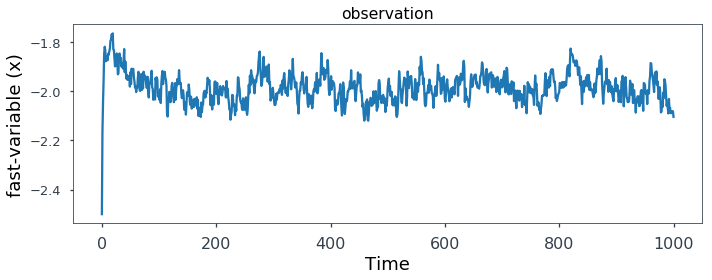

In [67]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.eps"), doi=800)
plt.show()

### Posterior HZ

In [68]:
num_samples=10000

In [69]:
posterior_samples = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [70]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_obs3_posterior_samples.npy') , posterior_samples)

In [71]:
num_params=posterior_samples.shape[1]

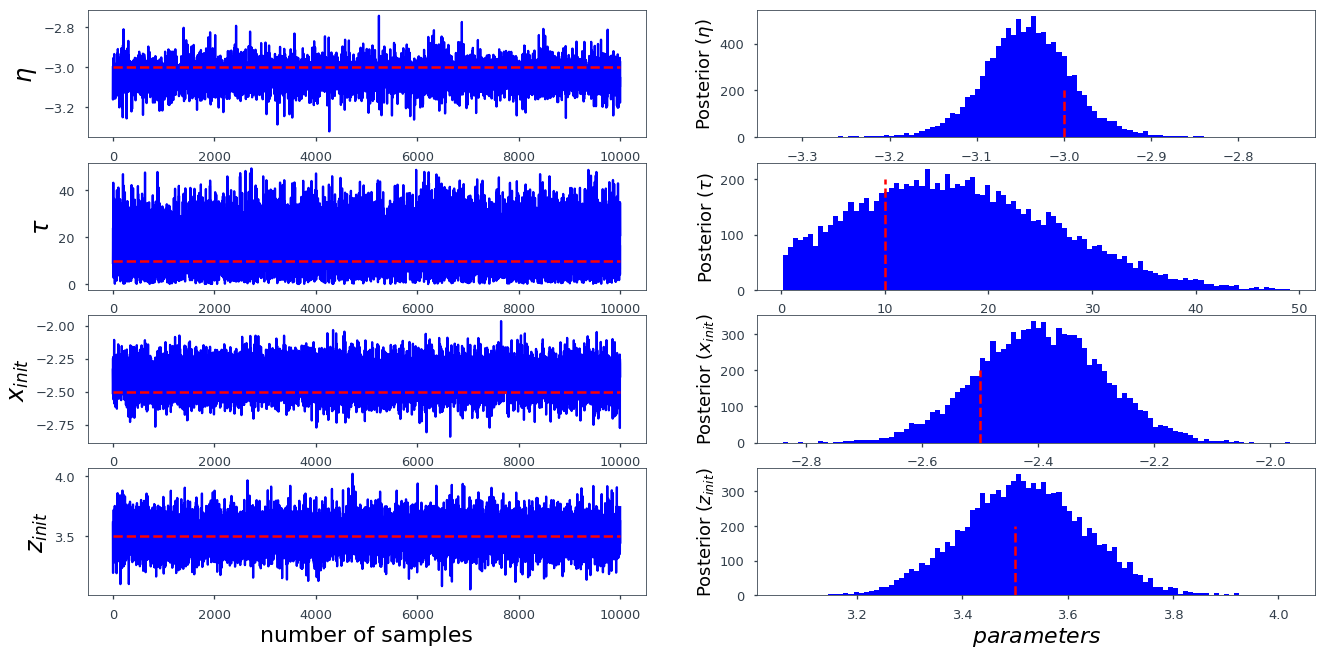

In [72]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.eps"), doi=800)    
plt.show()

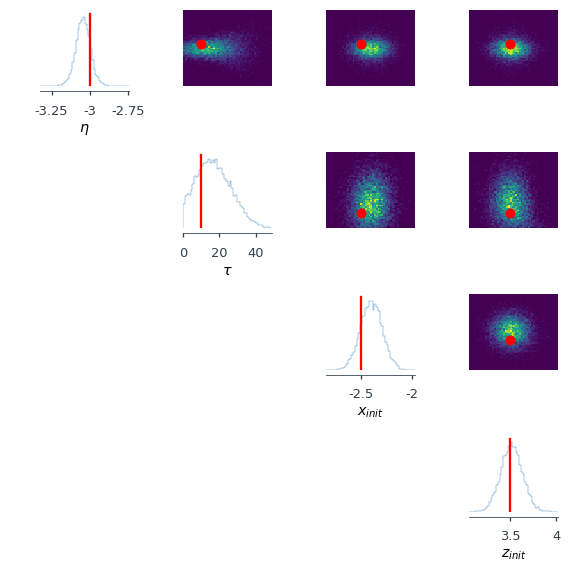

In [73]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.eps"), doi=800)  
plt.show()

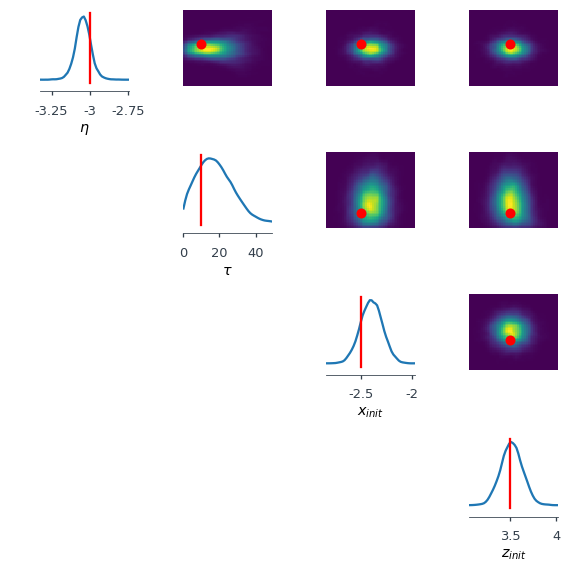

In [74]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.eps"), doi=800)
plt.show()

In [75]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [76]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [77]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_hz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_hz_y_fit.npy') , y_fit)

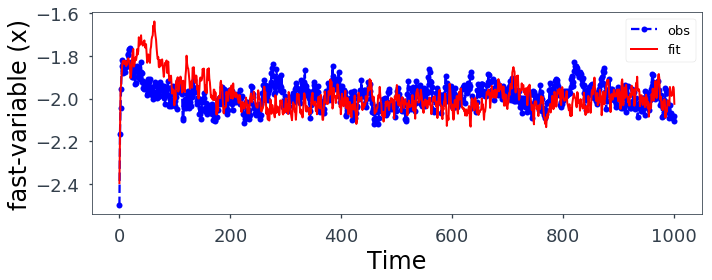

In [78]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.eps"), doi=800) 
plt.show()

In [79]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [80]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

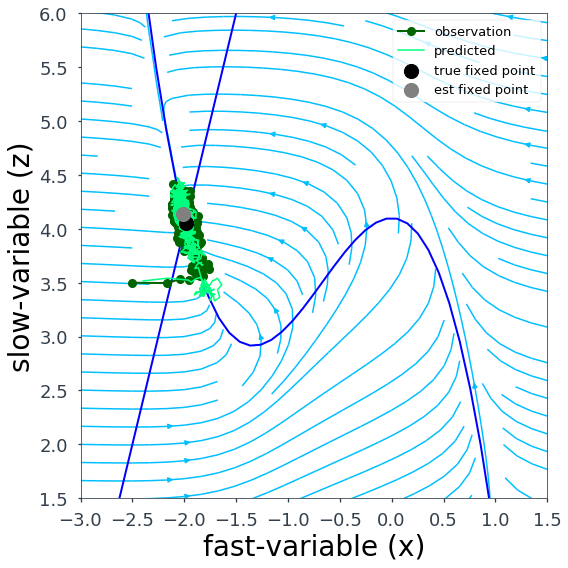

In [81]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkgreen', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='springgreen', alpha=1., linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='k', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='grey', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 6.])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_hz.eps"), doi=800) 
plt.show()